# Titanic Dataset Experiment
## Henry Salgado
### May 2025

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers
from sklearn.ensemble import RandomForestClassifier


Dataset variables can be found here: https://www.kaggle.com/c/titanic/data

In [72]:
import seaborn as sns
df = sns.load_dataset('titanic')
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [73]:
print(df.isnull().sum())

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


In [74]:
df = df.drop(columns=["deck"])
df = df.dropna()



In [75]:
df['sex'].value_counts()

male      453
female    259
Name: sex, dtype: int64

Let's one-hot encode categorical data 

In [76]:
df['sex'] = LabelEncoder().fit_transform(df['sex'])
df['embarked'] = LabelEncoder().fit_transform(df['embarked']) 
df['alone'] = LabelEncoder().fit_transform(df['alone'])
df['adult_male'] = LabelEncoder().fit_transform(df['adult_male'])  


In [77]:
df['sex'].value_counts()

1    453
0    259
Name: sex, dtype: int64

In [78]:
X = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = df['survived']

The following correlation table indicates that survival is mostly associated with your class and sex

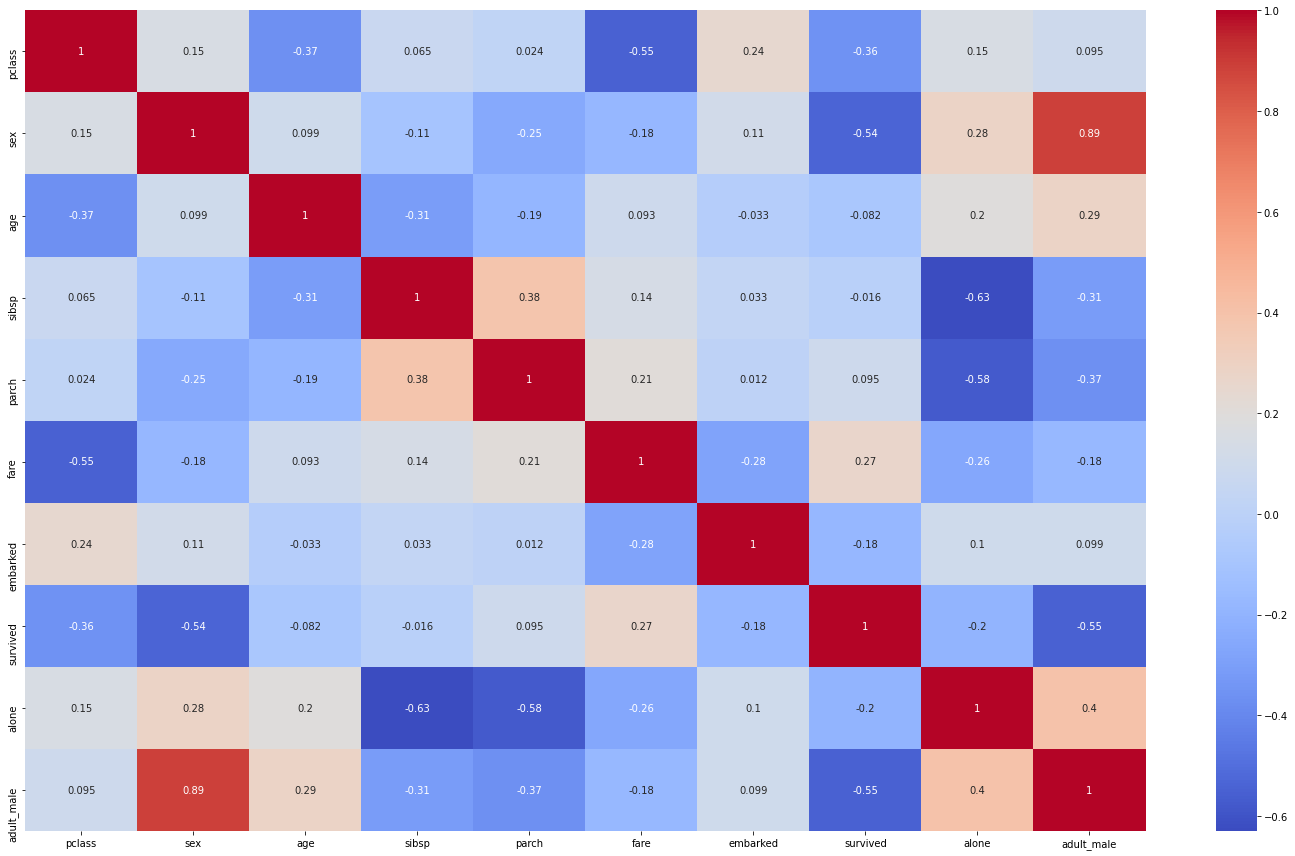

In [79]:
subset = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived', 'alone',  'adult_male']]

corr_matrix = subset.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = list(X_train.columns)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=16)


In [81]:

class TitanicNN(nn.Module):
    def __init__(self, input_dim):
       super(TitanicNN, self).__init__()
       self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
)

    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]
model = TitanicNN(input_dim)



These two configuration of ANN are arbitrary

In [82]:
class TitanicNN(nn.Module):
    def __init__(self, input_dim):
       super(TitanicNN, self).__init__()
       self.fc1 = nn.Linear(input_dim, 32)
       self.fc2 = nn.Linear(32, 64)
       self.fc3 = nn.ReLU()
       self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)


        return x


input_dim = X_train.shape[1]
model = TitanicNN(input_dim)

In [83]:
# Loss funct 
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [84]:
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

# Train the model
print("Training the model...")
train_model(model, train_loader, criterion, optimizer, epochs=100)


Training the model...
Epoch [20/100], Loss: 0.3849
Epoch [40/100], Loss: 0.3724
Epoch [60/100], Loss: 0.3574
Epoch [80/100], Loss: 0.3536
Epoch [100/100], Loss: 0.3451


In [85]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for xb, yb in test_loader:
        outputs = model(xb)
        predictions = (torch.sigmoid(outputs) >= 0.5).float()
        correct += (predictions == yb).sum().item()
        total += yb.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 80.42%


In [86]:
background = X_train_tensor[torch.randperm(X_train_tensor.shape[0])[:100]]
background.shape
samples_to_explain = X_test_tensor[:10]
samples_to_explain.shape

torch.Size([10, 7])

Computing SHAP values...
Creating SHAP plots...


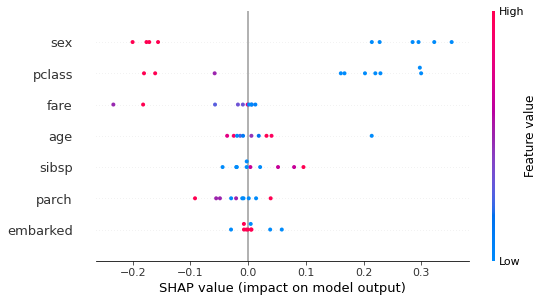

Creating additional SHAP visualizations...
Note: Positive SHAP values = increase survival probability
      Negative SHAP values = decrease survival probability

First sample prediction: Survived (probability: 0.985)
Baseline probability: 0.606


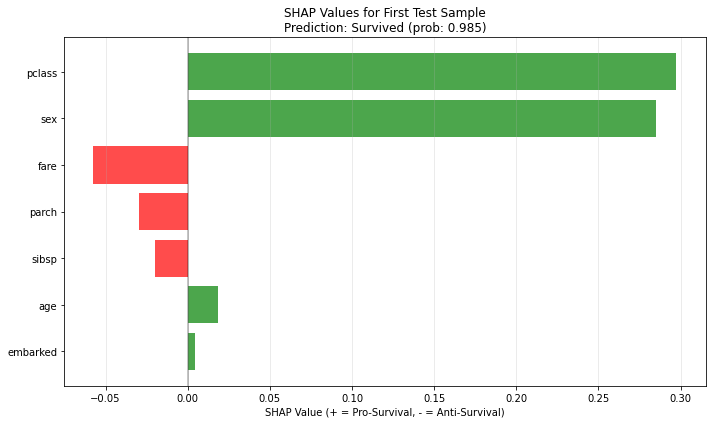

<Figure size 864x288 with 0 Axes>

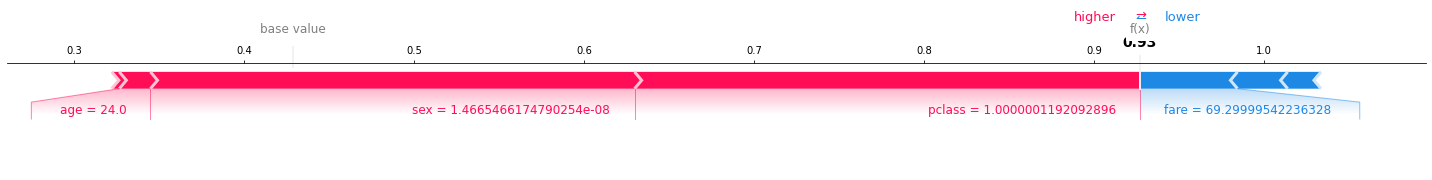


Top 5 Most Important Features for First Sample:
Sample prediction: Survived (probability: 0.985)
1. pclass: 0.2975 (PRO-survival)
   Feature value: 1.0000

2. sex: 0.2849 (PRO-survival)
   Feature value: 0.0000

3. fare: -0.0574 (ANTI-survival)
   Feature value: 69.3000

4. parch: -0.0295 (ANTI-survival)
   Feature value: -0.0000

5. sibsp: -0.0196 (ANTI-survival)
   Feature value: -0.0000

Evaluating model...
Test Accuracy: 80.42%


80.41958041958041

In [87]:
import shap

background = X_train_tensor[torch.randperm(X_train_tensor.shape[0])[:100]]
samples_to_explain = X_test_tensor[:10]

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        return torch.sigmoid(self.model(x))  

wrapped_model = WrappedModel(model)
wrapped_model.eval()


print("Computing SHAP values...")
explainer = shap.DeepExplainer(wrapped_model, background)

# Note SHAP values with additivity check disabled (due to BatchNorm)
shap_values = explainer.shap_values(samples_to_explain, check_additivity=False)



sample_df = pd.DataFrame(
    scaler.inverse_transform(samples_to_explain.detach().numpy()), 
    columns=feature_names
)


print("Creating SHAP plots...")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, features=sample_df.values, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()

print("Creating additional SHAP visualizations...")
print("Note: Positive SHAP values = increase survival probability")
print("      Negative SHAP values = decrease survival probability")

# Get prediction for first sample to show context
with torch.no_grad():
    raw_output = model(samples_to_explain[0:1])
    probability = torch.sigmoid(raw_output).item()
    prediction = "Survived" if probability > 0.5 else "Did not survive"

print(f"\nFirst sample prediction: {prediction} (probability: {probability:.3f})")
print(f"Baseline probability: {torch.sigmoid(torch.tensor(explainer.expected_value)).item():.3f}")


plt.figure(figsize=(10, 6))
sample_shap_values = shap_values[0]  
feature_importance = np.abs(sample_shap_values)
sorted_idx = np.argsort(feature_importance)


colors = ['red' if val < 0 else 'green' for val in sample_shap_values[sorted_idx]]

plt.barh(range(len(sorted_idx)), sample_shap_values[sorted_idx], color=colors, alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('SHAP Value (+ = Pro-Survival, - = Anti-Survival)')
plt.title(f'SHAP Values for First Test Sample\nPrediction: {prediction} (prob: {probability:.3f})')
plt.grid(axis='x', alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()


try:
    plt.figure(figsize=(12, 4))
    shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values[0], 
        features=sample_df.iloc[0],
        feature_names=feature_names,
        matplotlib=True,
        show=False
    )
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Force plot failed: {e}")


print(f"\nTop 5 Most Important Features for First Sample:")
print(f"Sample prediction: {prediction} (probability: {probability:.3f})")
print("="*60)
sample_shap_values = shap_values[0]
feature_importance = np.abs(sample_shap_values)
top_features_idx = np.argsort(feature_importance)[-5:][::-1]

for i, idx in enumerate(top_features_idx):
    shap_val = sample_shap_values[idx]
    effect = "PRO-survival" if shap_val > 0 else "ANTI-survival"
    print(f"{i+1}. {feature_names[idx]}: {shap_val:.4f} ({effect})")
    print(f"   Feature value: {sample_df.iloc[0, idx]:.4f}")
    print()


def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


print("Evaluating model...")
evaluate_model(model, test_loader)

This is good accuracy, but we ANNs are black boxes and we can't really see which features are driving the outcome. So, lets try a Decision tree

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree


In [89]:
from sklearn.tree import DecisionTreeClassifier


X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy().ravel()
X_test_np = X_test_tensor.numpy()
y_test_np = y_test_tensor.numpy().ravel()


clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train_np, y_train_np)

from sklearn.metrics import classification_report

y_pred = clf.predict(X_test_np)

print(classification_report(y_test_np, y_pred))



              precision    recall  f1-score   support

         0.0       0.70      0.95      0.80        80
         1.0       0.88      0.48      0.62        63

    accuracy                           0.74       143
   macro avg       0.79      0.71      0.71       143
weighted avg       0.78      0.74      0.72       143



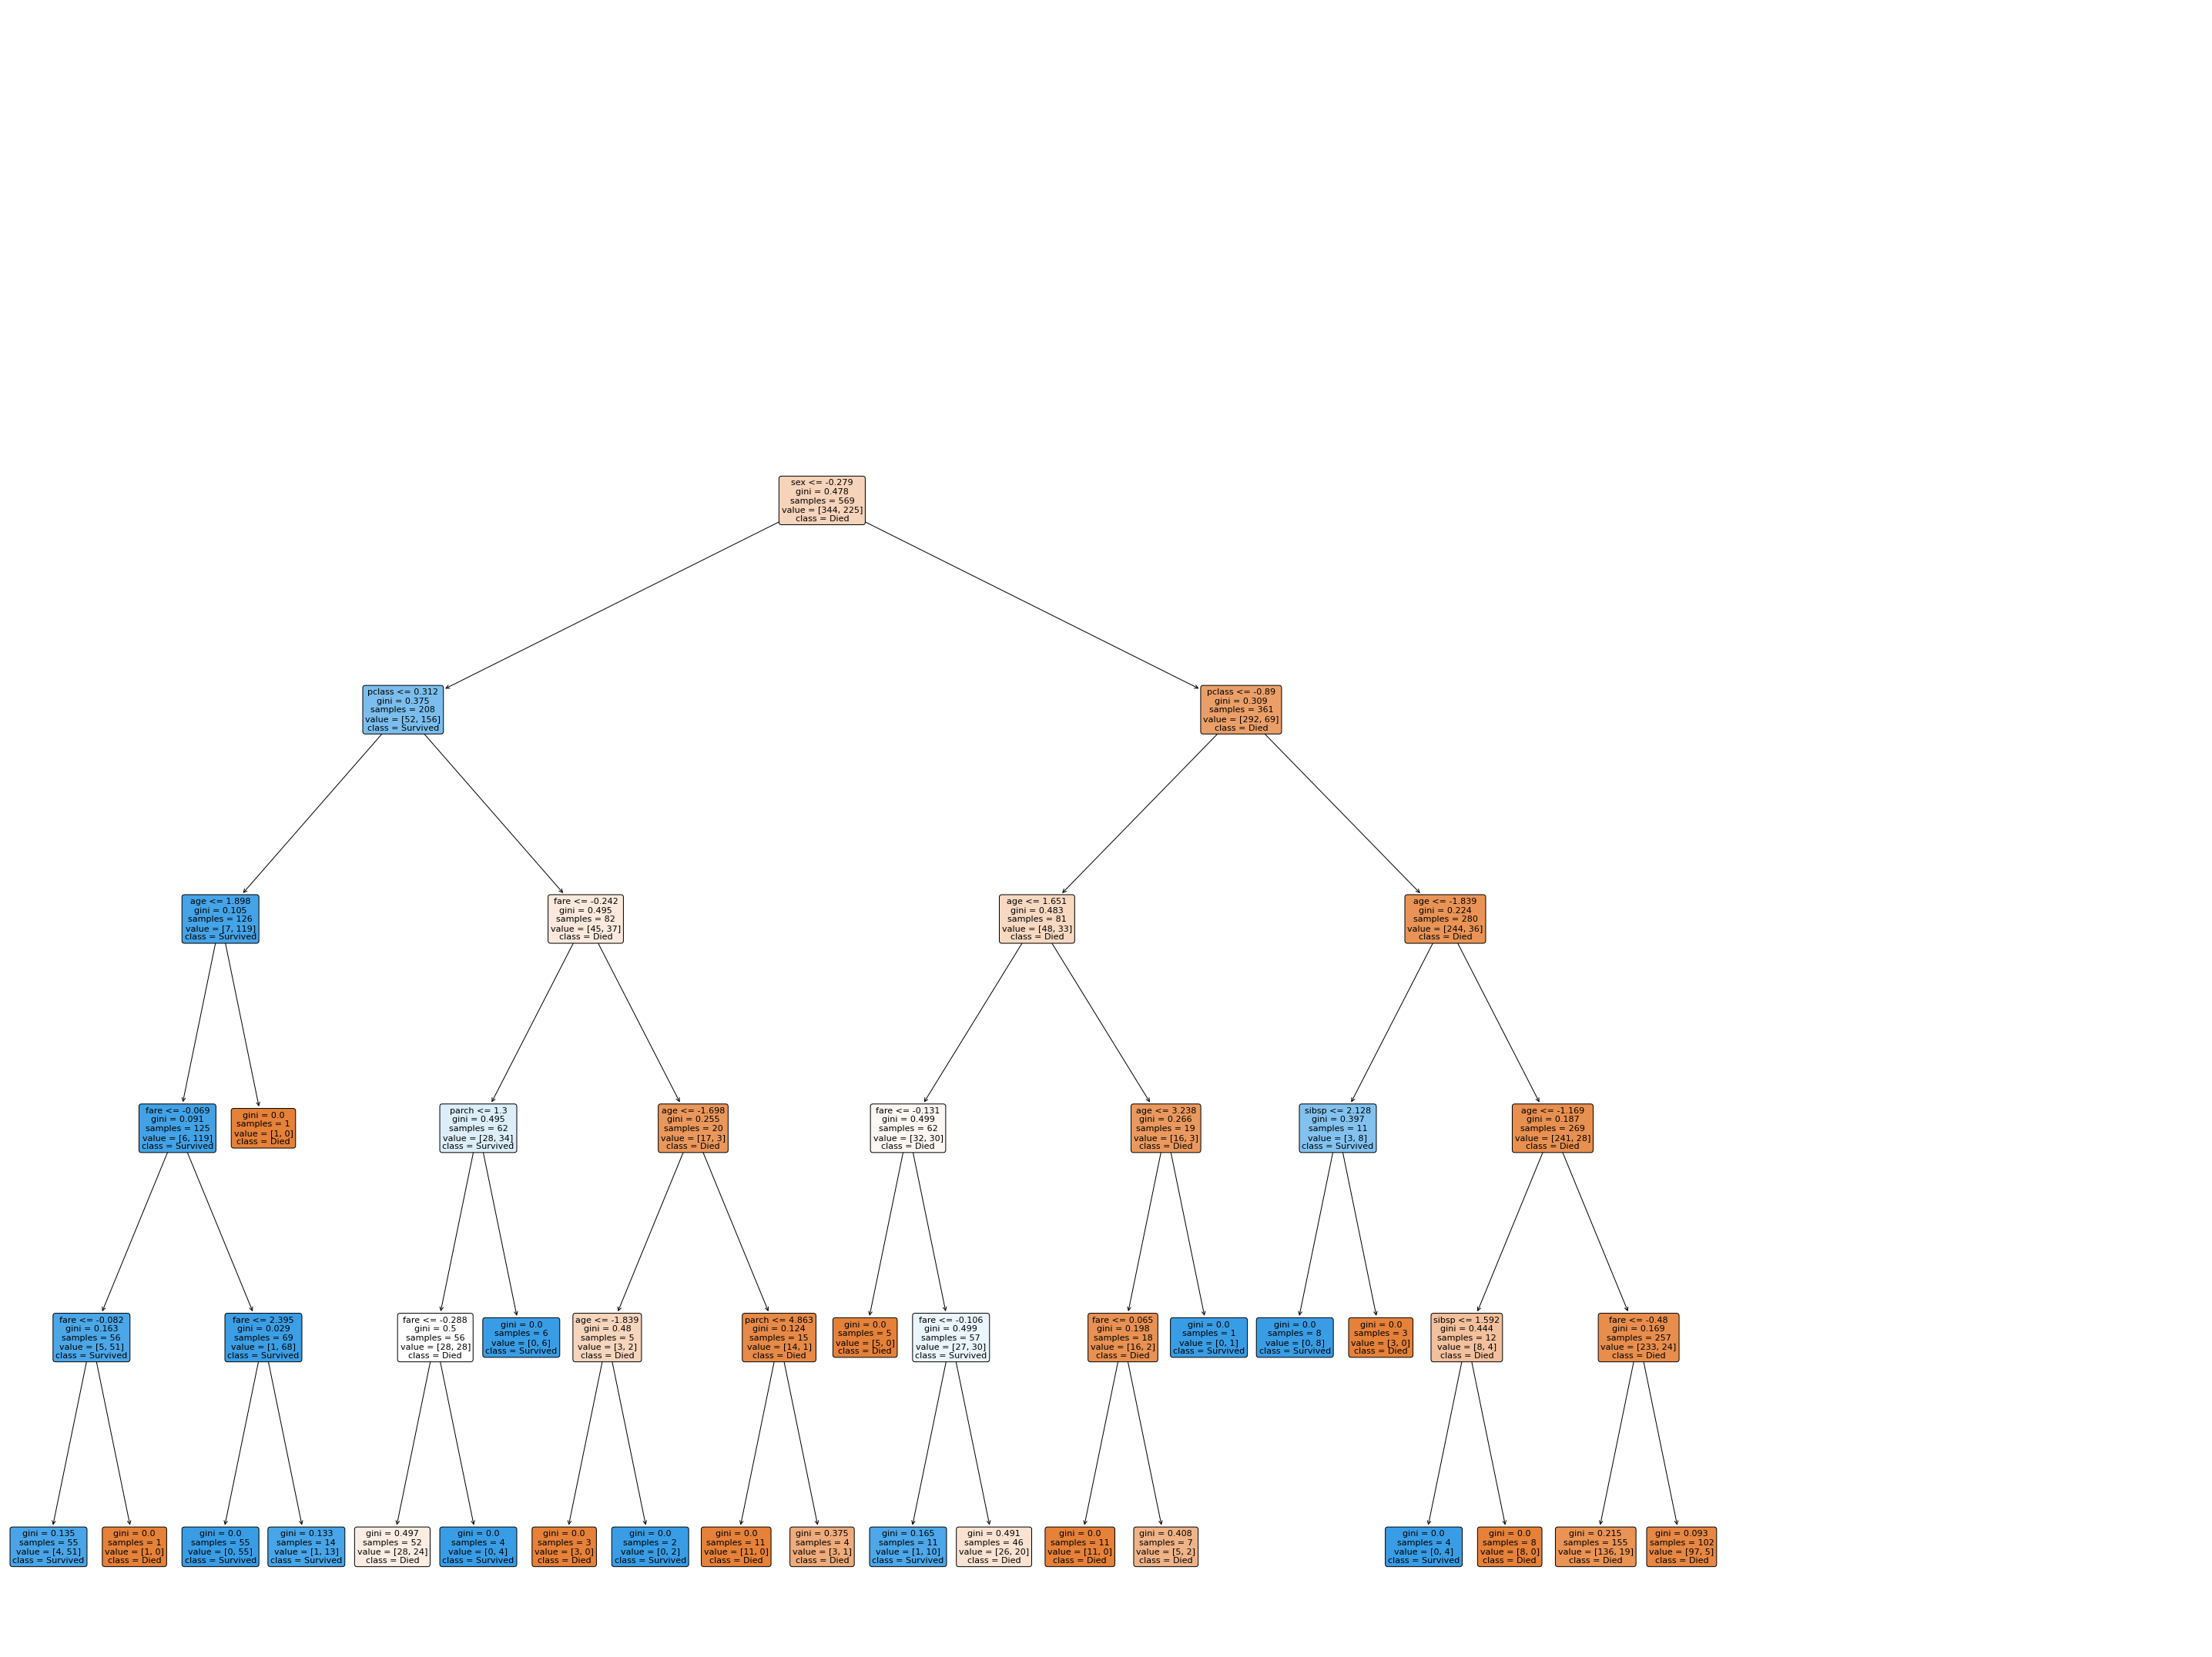

In [90]:
plt.figure(figsize=(40, 30))
tree.plot_tree(clf, 
               feature_names=['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked'], 
               class_names=['Died', 'Survived'],
               filled=True,
               rounded=True)
plt.show()


    Feature  Importance
1       sex    0.498690
0    pclass    0.205309
2       age    0.115837
5      fare    0.102890
3     sibsp    0.058663
4     parch    0.018611
6  embarked    0.000000


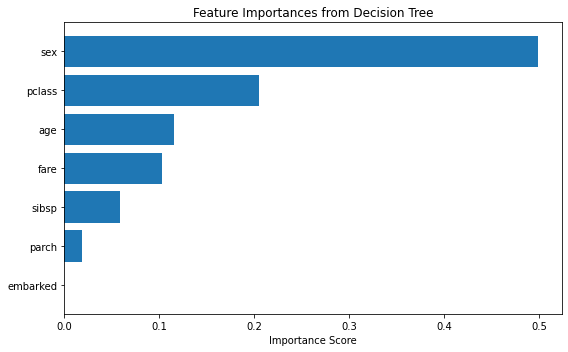

In [91]:
feature_names = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']


importances = clf.feature_importances_

feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_importances)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()
plt.show()

What about Causal Discovery?

Depth=1, working on node 3:  50%|█████     | 4/8 [00:00<00:00, 249.24it/s] 

PC Algo


Depth=2, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 731.59it/s] 


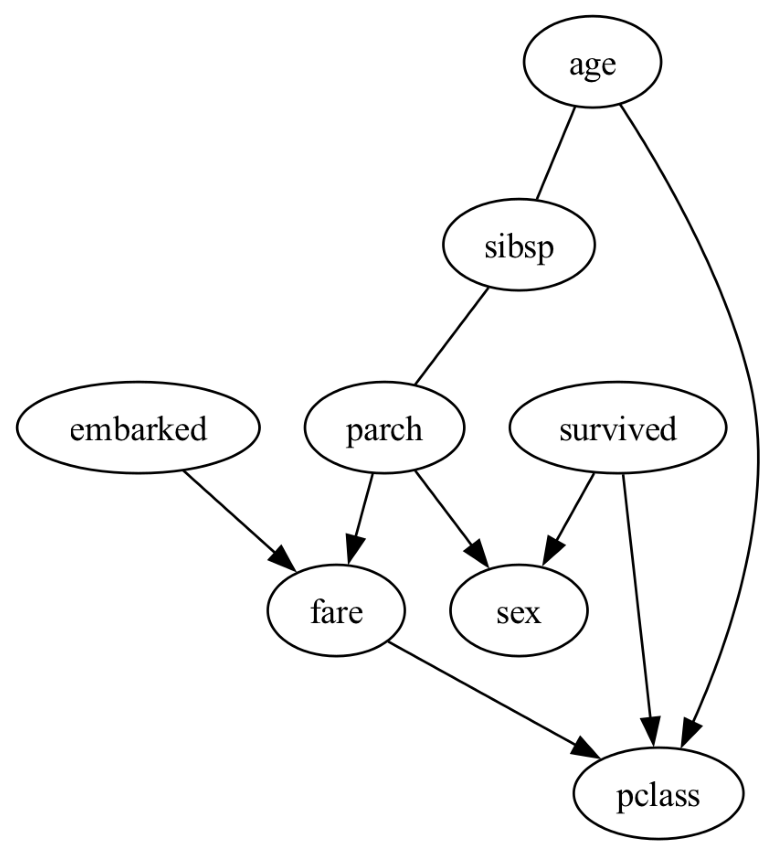

In [92]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.search.ConstraintBased.FCI import fci
from causallearn.utils.cit import fisherz, chisq, gsq
import matplotlib.pyplot as plt
from causallearn.utils.GraphUtils import GraphUtils
from IPython.display import Image, display
import pandas as pd

X = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
y = df['survived']

all_features = pd.concat([X, y], axis=1)


X_np = all_features.to_numpy()
col_names = list(all_features.columns)


print("PC Algo")
cg_pc = pc(X_np, alpha=0.01, ci_test=fisherz,  node_names=col_names)


cg_pc.draw_pydot_graph()

In [93]:
print("_______FCI_______")
cg_fci, sep_set = fci(X_np, alpha=0.001, ci_test=fisherz,  node_names=col_names)
pdy = GraphUtils.to_pydot(cg_fci)
pdy.write_png("fci_graph_titanic.png")

Depth=0, working on node 7: 100%|██████████| 8/8 [00:00<00:00, 591.85it/s]

_______FCI_______


In [94]:
from notears.linear import notears_linear
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Select and encode features
X = df[['pclass', 'sex', 'age', 'fare', 'sibsp', 'parch', 'embarked', 'survived']]
X_encoded = pd.get_dummies(X, drop_first=True)
X_scaled = StandardScaler().fit_transform(X_encoded)
col_names = list(X_encoded.columns)

W_est = notears_linear(X_scaled, loss_type='l2', lambda1=0.01)


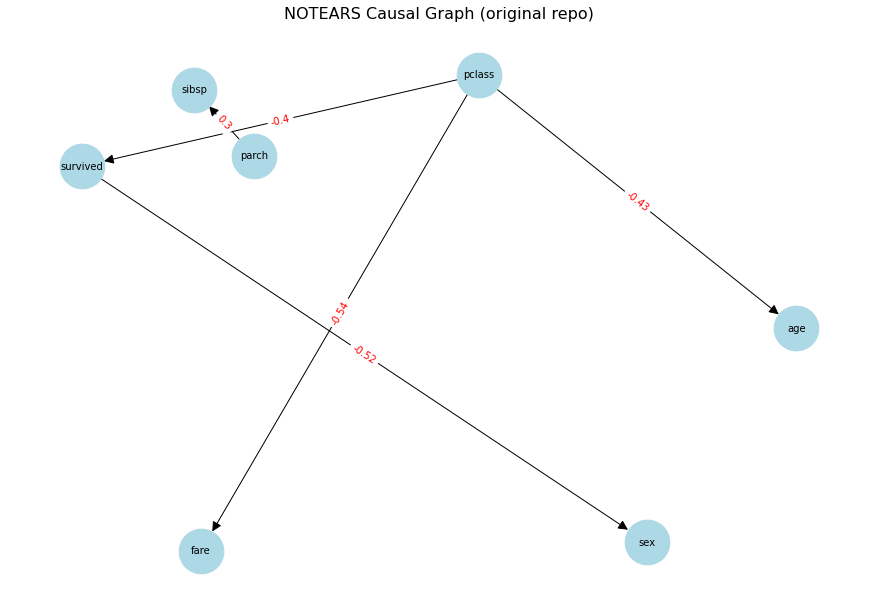

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph()

n = len(col_names)
for i in range(n):
    for j in range(n):
        weight = W_est[i, j]
        if abs(weight) > 1e-3: 
            G.add_edge(col_names[i], col_names[j], weight=round(weight, 2))


plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("NOTEARS Causal Graph (original repo)", fontsize=16)
plt.axis('off')
plt.show()


In [96]:
import pandas as pd
import numpy as np
from causallearn.search.FCMBased.ANM.ANM import ANM


data = df[['sex', 'survived']].copy()
data = data.dropna()

print(f"Using {len(data)} samples")
print(f"Sex distribution: {data['sex'].value_counts().to_dict()}")
print(f"Survival distribution: {data['survived'].value_counts().to_dict()}")


sex = data['sex'].values.reshape(-1, 1).astype(float)
survived = data['survived'].values.reshape(-1, 1).astype(float)

# Run ANM
anm = ANM()
p_sex_to_survived, p_survived_to_sex = anm.cause_or_effect(sex, survived)

# Results
print(f"\nResults:")
print(f"Sex → Survived: p-value = {p_sex_to_survived:.4f}")
print(f"Survived → Sex: p-value = {p_survived_to_sex:.4f}")

if p_sex_to_survived < p_survived_to_sex:
    print("Suggested direction: Sex → Survived")
else:
    print("Suggested direction: Survived → Sex")

Using 712 samples
Sex distribution: {1: 453, 0: 259}
Survival distribution: {0: 424, 1: 288}

Results:
Sex → Survived: p-value = 0.0000
Survived → Sex: p-value = 0.0000
Suggested direction: Survived → Sex


In [97]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Traditional Statistical Analysis
print("=== TRADITIONAL STATISTICAL ANALYSIS ===")
# Cross-tabulation
crosstab = pd.crosstab(df['sex'], df['survived'], margins=True)
print("Cross-tabulation (Sex vs Survived):")
print(crosstab)

# Chi-square test
chi2, p_val, dof, expected = chi2_contingency(crosstab.iloc[:-1, :-1])
print(f"\nChi-square test:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_val:.6f}")
print(f"Degrees of freedom: {dof}")

# Survival rates by sex
survival_by_sex = df.groupby('sex')['survived'].agg(['count', 'sum', 'mean'])
survival_by_sex.columns = ['Total', 'Survived', 'Survival_Rate']
print(f"\nSurvival rates:")
print(survival_by_sex)

print("\n" + "="*50)

# 2. Logical Causal Reasoning
print("=== CAUSAL REASONING ===")
print("Based on domain knowledge:")
print("✓ Sex is determined at birth (biological)")
print("✓ Survival is an outcome of the Titanic disaster")
print("✓ Sex could influence survival (social factors, 'women and children first')")
print("✗ Survival cannot cause sex (temporal impossibility)")
print("\nConclusion: Sex → Survival is the only logical direction")

print("\n" + "="*50)

# 3. Predictive Analysis
print("=== PREDICTIVE ANALYSIS ===")
X_sex = df[['sex']]
y_survived = df['survived']

# Logistic regression: Sex predicting Survival
lr_sex_to_survival = LogisticRegression()
lr_sex_to_survival.fit(X_sex, y_survived)
accuracy_sex_to_survival = lr_sex_to_survival.score(X_sex, y_survived)

print(f"Sex → Survival prediction accuracy: {accuracy_sex_to_survival:.4f}")

# Reverse: Survival predicting Sex (just for comparison)
X_survived = df[['survived']]
y_sex = df['sex']

lr_survival_to_sex = LogisticRegression()
lr_survival_to_sex.fit(X_survived, y_sex)
accuracy_survival_to_sex = lr_survival_to_sex.score(X_survived, y_sex)

print(f"Survival → Sex prediction accuracy: {accuracy_survival_to_sex:.4f}")
print("\nNote: High accuracy in both directions doesn't imply causation!")

print("\n" + "="*50)

# 4. Effect Size Analysis
print("=== EFFECT SIZE ANALYSIS ===")
# Calculate odds ratio
contingency_table = pd.crosstab(df['sex'], df['survived'])
if contingency_table.shape == (2, 2):
    a, b = contingency_table.iloc[0, 0], contingency_table.iloc[0, 1]
    c, d = contingency_table.iloc[1, 0], contingency_table.iloc[1, 1]
    
    odds_ratio = (a * d) / (b * c) if (b * c) != 0 else float('inf')
    print(f"Odds ratio: {odds_ratio:.4f}")
    print(f"This means: {'Females' if odds_ratio > 1 else 'Males'} were {abs(odds_ratio):.2f}x more likely to survive")

# Cramér's V (effect size for categorical variables)
cramers_v = np.sqrt(chi2 / (len(df) * (min(crosstab.shape) - 1)))
print(f"Cramér's V (effect size): {cramers_v:.4f}")
if cramers_v < 0.1:
    effect_size = "negligible"
elif cramers_v < 0.3:
    effect_size = "small"
elif cramers_v < 0.5:
    effect_size = "medium"
else:
    effect_size = "large"
print(f"Effect size interpretation: {effect_size}")

print("\n" + "="*50)

# 5. Recommendations
print("=== RECOMMENDATIONS ===")
print("For binary causal discovery, consider:")
print("1. Domain knowledge (most important)")
print("2. Temporal ordering (cause must precede effect)")
print("3. PC Algorithm or GES for discrete variables")
print("4. Conditional independence tests")
print("5. Avoid ANM for binary variables")

print(f"\nFINAL CONCLUSION:")
print(f"The causal direction is clearly: Sex → Survival")
print(f"ANM gave misleading results due to binary variable limitations.")

=== TRADITIONAL STATISTICAL ANALYSIS ===
Cross-tabulation (Sex vs Survived):
survived    0    1  All
sex                    
0          64  195  259
1         360   93  453
All       424  288  712

Chi-square test:
Chi-square statistic: 202.8694
P-value: 0.000000
Degrees of freedom: 1

Survival rates:
     Total  Survived  Survival_Rate
sex                                
0      259       195       0.752896
1      453        93       0.205298

=== CAUSAL REASONING ===
Based on domain knowledge:
✓ Sex is determined at birth (biological)
✓ Survival is an outcome of the Titanic disaster
✓ Sex could influence survival (social factors, 'women and children first')
✗ Survival cannot cause sex (temporal impossibility)

Conclusion: Sex → Survival is the only logical direction

=== PREDICTIVE ANALYSIS ===
Sex → Survival prediction accuracy: 0.7795
Survival → Sex prediction accuracy: 0.7795

Note: High accuracy in both directions doesn't imply causation!

=== EFFECT SIZE ANALYSIS ===
Odds ratio: 

=== PREPARING DATA FOR GES ===
Selected variables: ['sex', 'pclass', 'age', 'survived', 'embarked', 'parch', 'sibsp']
Original data shape: (712, 7)
Missing values per column:
sex         0
pclass      0
age         0
survived    0
embarked    0
parch       0
sibsp       0
dtype: int64
Data shape after cleaning: (712, 7)
Final data shape: (712, 7)

=== RUNNING GES ALGORITHM ===
This may take a moment...
GES completed successfully!

=== CAUSAL GRAPH RESULTS ===
Discovered causal relationships:
  pclass → age
  pclass → survived
  embarked → pclass

Total edges found: 3

=== VISUALIZING CAUSAL GRAPH ===


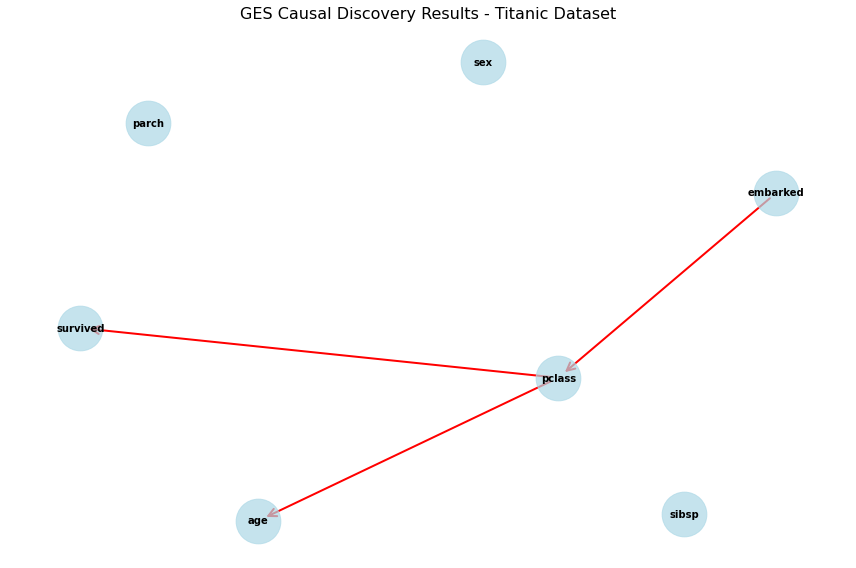


=== SURVIVAL-RELATED CAUSAL RELATIONSHIPS ===
Variables that causally influence survival:
  ✓ pclass → survived

Variables causally influenced by survival:
  None found

=== INTERPRETATION ===
Sex and Survival relationship:
  ○ No direct causal relationship detected

Other interesting patterns:
  • pclass → survived

Note: GES finds patterns in the data, but domain knowledge
should be used to validate causal interpretations.

=== ADDITIONAL STATISTICS ===
Correlation matrix (for reference):
            sex  pclass    age  survived  embarked  parch  sibsp
sex       1.000   0.151  0.099    -0.537     0.110 -0.250 -0.106
pclass    0.151   1.000 -0.366    -0.356     0.244  0.024  0.065
age       0.099  -0.366  1.000    -0.082    -0.033 -0.188 -0.307
survived -0.537  -0.356 -0.082     1.000    -0.182  0.095 -0.016
embarked  0.110   0.244 -0.033    -0.182     1.000  0.012  0.033
parch    -0.250   0.024 -0.188     0.095     0.012  1.000  0.383
sibsp    -0.106   0.065 -0.307    -0.016     0.0

In [123]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from causallearn.search.ScoreBased.GES import ges

# Prepare data for GES
print("=== PREPARING DATA FOR GES ===")

# Select relevant variables (you can add more)
variables = ['sex', 'pclass', 'age',  'survived', 'embarked', 'parch', 'sibsp']
data = df[variables].copy()

print(f"Selected variables: {variables}")
print(f"Original data shape: {data.shape}")

# Handle missing values
print(f"Missing values per column:")
print(data.isnull().sum())

# Fill missing values
data['age'] = data['age'].fillna(data['age'].median())
#data['fare'] = data['fare'].fillna(data['fare'].median())
data = data.dropna()

print(f"Data shape after cleaning: {data.shape}")

# Convert to numpy array (GES expects this format)
data_array = data.values.astype(float)
variable_names = list(data.columns)

print(f"Final data shape: {data_array.shape}")

print("\n" + "="*60)

# Run GES algorithm
print("=== RUNNING GES ALGORITHM ===")
print("This may take a moment...")

# Run GES
Record = ges(data_array)

# Extract results
causal_graph = Record['G'].graph
print("GES completed successfully!")

print("\n" + "="*60)

# Analyze results
print("=== CAUSAL GRAPH RESULTS ===")

# Convert adjacency matrix to readable format
n_vars = len(variable_names)
edges = []
for i in range(n_vars):
    for j in range(n_vars):
        if causal_graph[i, j] == 1:  # Edge from i to j
            edges.append((variable_names[i], variable_names[j]))

print(f"Discovered causal relationships:")
if edges:
    for source, target in edges:
        print(f"  {source} → {target}")
else:
    print("  No direct causal relationships found")

print(f"\nTotal edges found: {len(edges)}")

print("\n" + "="*60)

# Visualize the causal graph
print("=== VISUALIZING CAUSAL GRAPH ===")

# Create NetworkX graph
G = nx.DiGraph()
G.add_nodes_from(variable_names)
G.add_edges_from(edges)

# Create visualization
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=2, iterations=50)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                       node_size=2000, alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='red', 
                       arrows=True, arrowsize=20, 
                       arrowstyle='->', width=2)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("GES Causal Discovery Results - Titanic Dataset", fontsize=16, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n" + "="*60)

# Focus on survival-related relationships
print("=== SURVIVAL-RELATED CAUSAL RELATIONSHIPS ===")

survival_causes = [edge for edge in edges if edge[1] == 'survived']
survival_effects = [edge for edge in edges if edge[0] == 'survived']

print("Variables that causally influence survival:")
if survival_causes:
    for source, target in survival_causes:
        print(f"  ✓ {source} → survived")
else:
    print("  None found")

print("\nVariables causally influenced by survival:")
if survival_effects:
    for source, target in survival_effects:
        print(f"  ✓ survived → {target}")
else:
    print("  None found")

print("\n" + "="*60)

# Summary and interpretation
print("=== INTERPRETATION ===")

sex_to_survival = ('sex', 'survived') in edges
survival_to_sex = ('survived', 'sex') in edges

print("Sex and Survival relationship:")
if sex_to_survival and not survival_to_sex:
    print("  ✓ Sex → Survival (makes sense!)")
elif survival_to_sex and not sex_to_survival:
    print("  ✗ Survival → Sex (counterintuitive)")
elif sex_to_survival and survival_to_sex:
    print("  ? Bidirectional relationship found")
else:
    print("  ○ No direct causal relationship detected")

print(f"\nOther interesting patterns:")
# Look for chains involving survival
for edge in edges:
    if edge[0] not in ['sex', 'survived'] and edge[1] == 'survived':
        print(f"  • {edge[0]} → survived")
    elif edge[0] == 'survived' and edge[1] not in ['sex']:
        print(f"  • survived → {edge[1]}")

print(f"\nNote: GES finds patterns in the data, but domain knowledge")
print(f"should be used to validate causal interpretations.")

print("\n" + "="*60)

# Additional analysis
print("=== ADDITIONAL STATISTICS ===")
print("Correlation matrix (for reference):")
correlation_matrix = data.corr()
print(correlation_matrix.round(3))

# Show strongest correlations with survival
survival_corr = correlation_matrix['survived'].abs().sort_values(ascending=False)
print(f"\nStrongest correlations with survival:")
for var, corr in survival_corr.items():
    if var != 'survived':
        print(f"  {var}: {corr:.3f}")

Can we intervene?

In [111]:
import pandas as pd
import dice_ml
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder


subset = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']].dropna()
for col in ['sex', 'embarked']:
    subset[col] = LabelEncoder().fit_transform(subset[col])


X = subset.drop('survived', axis=1)
clf = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X, subset['survived'])


dice = dice_ml.Dice(
    dice_ml.Data(dataframe=subset, continuous_features=['age', 'fare'], outcome_name='survived'),
    dice_ml.Model(model=clf, backend="sklearn")
)


query = pd.DataFrame([[3, 0, 22, 1, 0, 7.25, 0]], columns=X.columns)
dice_exp = dice.generate_counterfactuals(
    query, 
    total_CFs=5, 
    desired_class="opposite",
    features_to_vary=['sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
)
dice_exp.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

Query instance (original outcome : 0)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,22,1,0,7.25,0,0



Diverse Counterfactual set (new outcome: 1)


,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,4,1,0,7.25,0,1
1,3,0,1,0,0,7.25,0,1
2,3,0,3,1,2,7.25,0,1
3,3,0,4,1,0,7.25,2,1
4,3,0,6,0,0,7.25,0,1


Lets try ARG

In [112]:
arg_data = df.copy()
arg_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,Third,man,1,Southampton,no,0
1,1,1,0,38.0,1,0,71.2833,0,First,woman,0,Cherbourg,yes,0
2,1,3,0,26.0,0,0,7.9250,2,Third,woman,0,Southampton,yes,1
3,1,1,0,35.0,1,0,53.1000,2,First,woman,0,Southampton,yes,0
4,0,3,1,35.0,0,0,8.0500,2,Third,man,1,Southampton,no,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,39.0,0,5,29.1250,1,Third,woman,0,Queenstown,no,0
886,0,2,1,27.0,0,0,13.0000,2,Second,man,1,Southampton,no,1
887,1,1,0,19.0,0,0,30.0000,2,First,woman,0,Southampton,yes,1
889,1,1,1,26.0,0,0,30.0000,0,First,man,1,Cherbourg,yes,1


Contingency Table (eg Counts)

In [113]:
pd.crosstab(df['survived'], df['pclass'], normalize='index')


pclass,1,2,3
survived,,,
0,0.150943,0.212264,0.636792
1,0.416667,0.288194,0.295139


Probability of both events occurring together: P(A∩B), all values add up to 1

In [114]:
joint = pd.crosstab(df['survived'], df['pclass'], normalize=True)
joint


pclass,1,2,3
survived,,,
0,0.089888,0.126404,0.379213
1,0.168539,0.116573,0.119382


Conditional Probability, P(survived = 1 | pclass = 3). Columns add up to 1

What is the probability that a passenger is from 3rd class, given that they did not survive?

In [115]:
prob = df[(df['pclass'] == 1) & (df['survived'] == 0)].shape[0] / df[df['survived'] == 0].shape[0]
print(f"P(survived=1 | pclass=3) = {prob:.3f}")


P(survived=1 | pclass=3) = 0.151


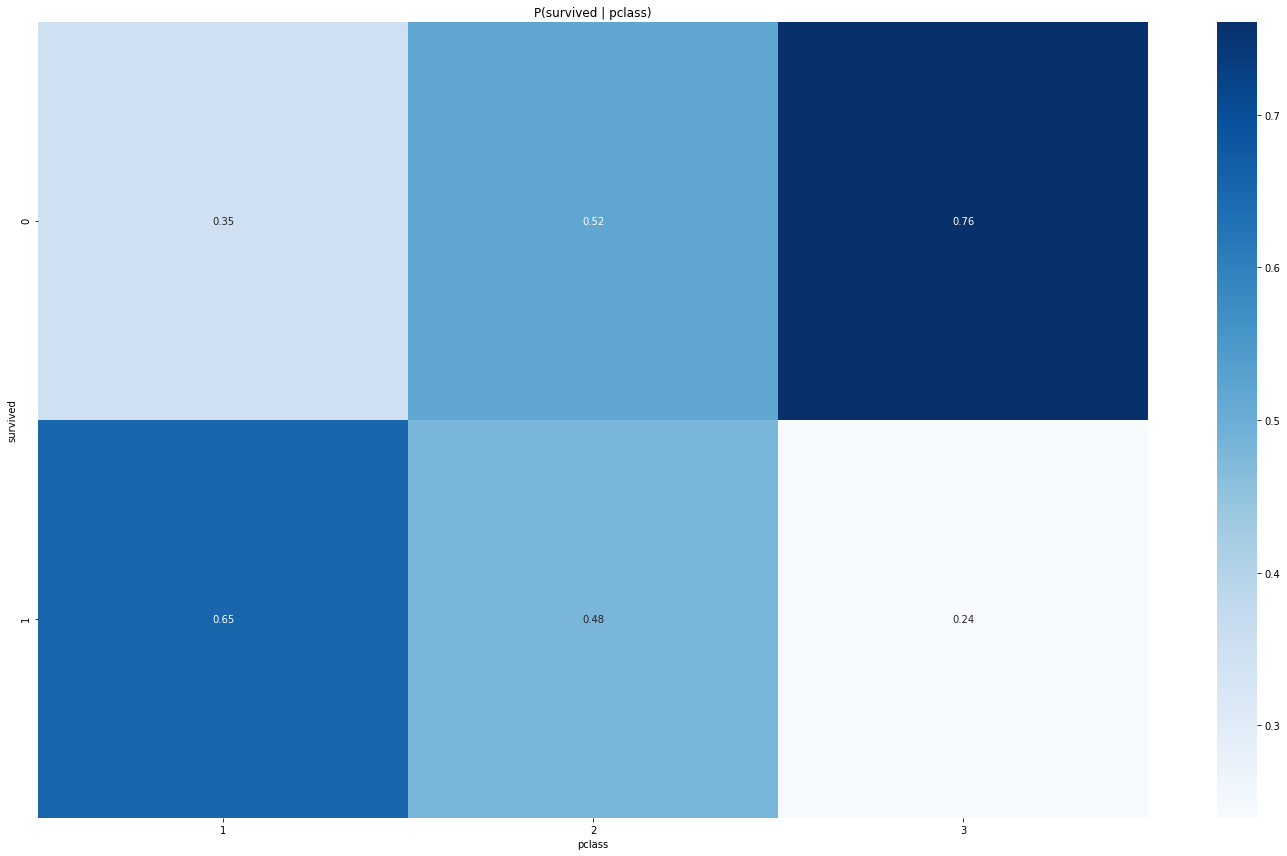

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = pd.crosstab(df['survived'], df['pclass'], normalize='columns')
sns.heatmap(heatmap_data, annot=True, cmap='Blues')
plt.title('P(survived | pclass)')
plt.show()


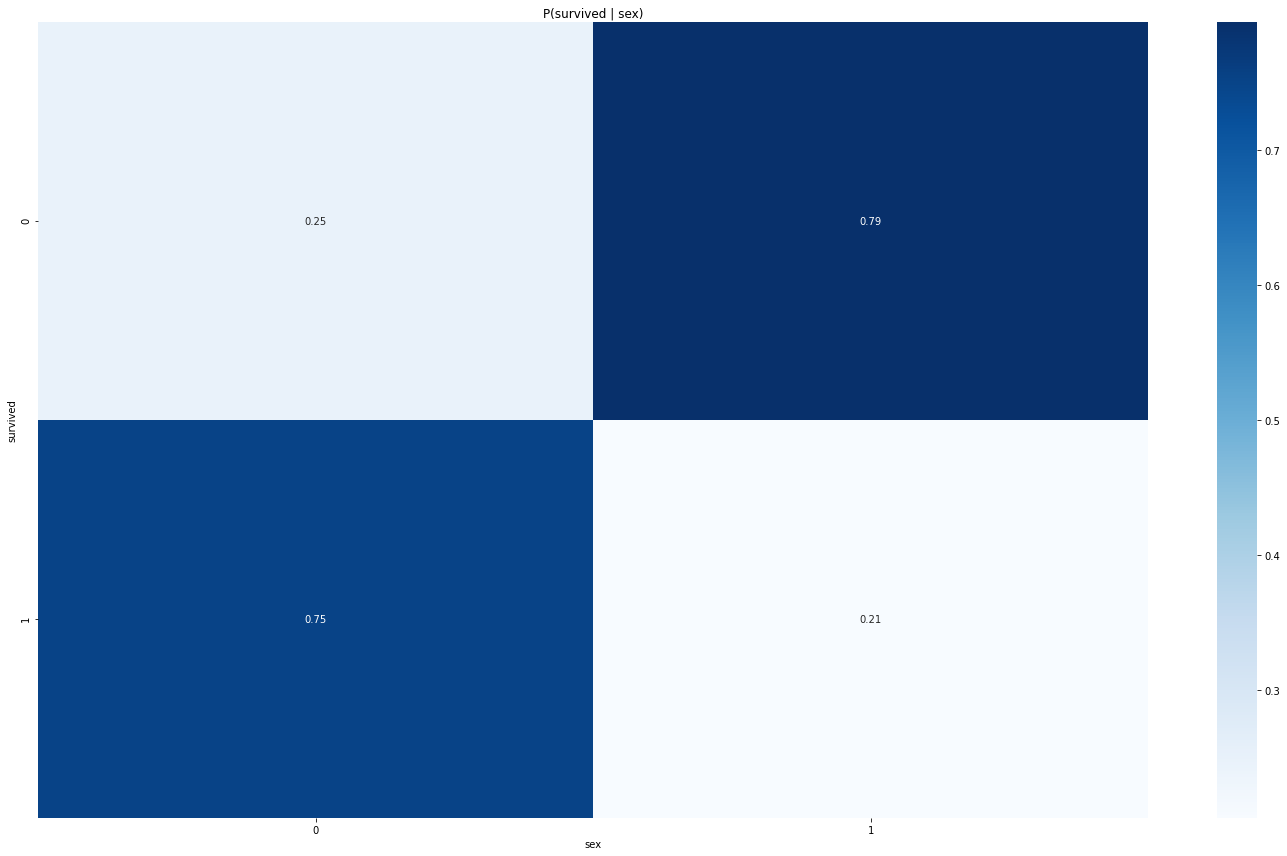

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = pd.crosstab(df['survived'], df['sex'], normalize='columns')
sns.heatmap(heatmap_data, annot=True, cmap='Blues')
plt.title('P(survived | sex)')
plt.show()


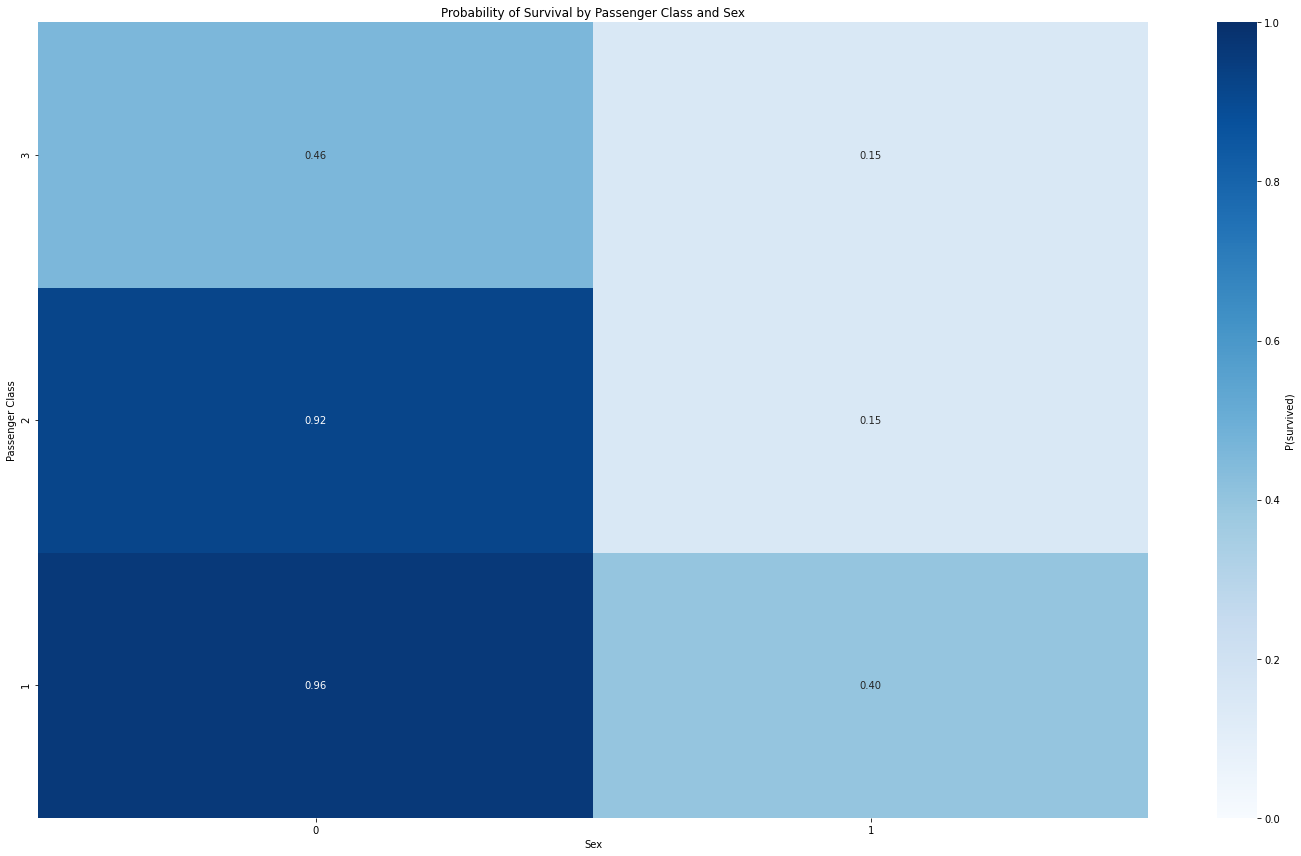

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = (
    df.pivot_table(index="pclass",
                   columns="sex",
                   values="survived",
                   aggfunc="mean")
      .sort_index(ascending=False)
)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    vmin=0, vmax=1,
    cbar_kws={"label": "P(survived)"},
)

plt.title("Probability of Survival by Passenger Class and Sex")
plt.ylabel("Passenger Class")
plt.xlabel("Sex")
plt.show()


In [119]:
arg_data = df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']]

In [120]:
arg_data_encoded = pd.get_dummies(arg_data, columns=["pclass", "sex", ])
arg_data_encoded

,age,sibsp,parch,fare,embarked,survived,pclass_1,pclass_2,pclass_3,sex_0,sex_1
0,22.0,1,0,7.2500,2,0,0,0,1,0,1
1,38.0,1,0,71.2833,0,1,1,0,0,1,0
2,26.0,0,0,7.9250,2,1,0,0,1,1,0
3,35.0,1,0,53.1000,2,1,1,0,0,1,0
4,35.0,0,0,8.0500,2,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
885,39.0,0,5,29.1250,1,0,0,0,1,1,0
886,27.0,0,0,13.0000,2,0,0,1,0,0,1
887,19.0,0,0,30.0000,2,1,1,0,0,1,0
889,26.0,0,0,30.0000,0,1,1,0,0,0,1


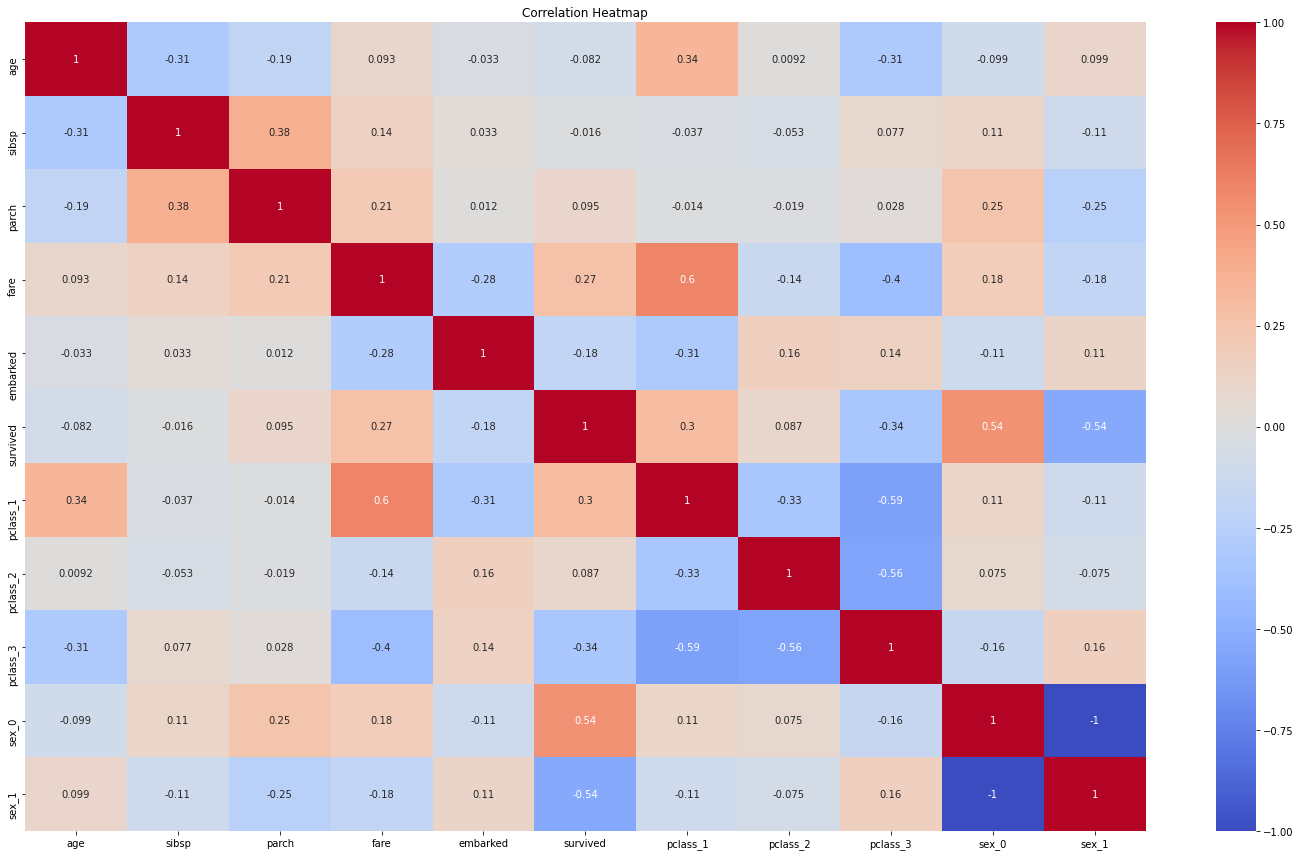

In [121]:
corr_matrix = arg_data_encoded.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()
